# Forecasting

## 1. Pre-set

In [83]:
#Import required packages
import warnings
warnings.filterwarnings("ignore")
import os
import itertools
import pandas as pd
import numpy as np
from datetime import datetime
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import sktime
from sktime.forecasting.model_selection import temporal_train_test_split
from dateutil.parser import parse
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [28]:
#Load the file, c
df = pd.read_csv("peajes_caba_1.csv")
df.head(1)

,estacion,fecha,cantidad_pasos,fecha.1,dia,mes,año
0,alberdi,1/1/2016,5446.0,1,Friday,1,2016


In [4]:
df.columns #to have in writing 

Index(['estacion', 'fecha', 'cantidad_pasos', 'fecha.1', 'dia', 'mes', 'año'], dtype='object')

In [5]:
#Completeness check of the time series, multiple record check, empty record check
df.año.value_counts()

2016    366
2017    365
2018    365
2019    365
1900      1
Name: año, dtype: int64

In [6]:
#Typecasting to date 
df["fecha"] = pd.to_datetime(df["fecha"])

In [168]:
#Assign date as index to convert in time series 
df_st = df.set_index("fecha").dropna()
df_st.head(1)

,estacion,cantidad_pasos,fecha.1,dia,mes,año
fecha,,,,,,
1/1/2016,alberdi,5446.0,1,Friday,1,2016


## 2.Exploratory Data Analysis

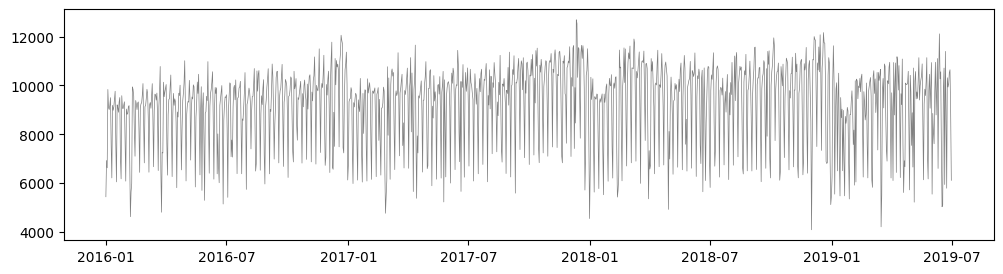

In [38]:
#Visually inspect time series
fig, ax = plt.subplots(figsize=(12, 3))
ax.plot(df_st.cantidad_pasos, linewidth=0.5, color="gray")

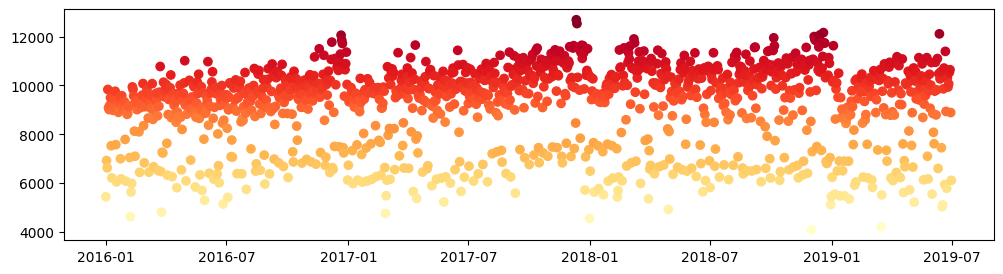

In [27]:
#Visualize the data in a scatter plot 
fig, ax = plt.subplots(figsize=(12, 3))
ax.scatter(df_st.index, df_st.cantidad_pasos, c=df_st.cantidad_pasos, cmap="YlOrRd")

At first sight: 
- No long term trend observed
- 1-year cyclicality: low values in january and growing towards december 
- Micro-cycles: less movements during weekends and towards the end of the month, with much higher values during the week 
- Rolling averages might be used to predict, splitting days & months 
- Higher variance is observed towards the end of the dataset 

Text(0.5, 1.0, 'Step count per day')

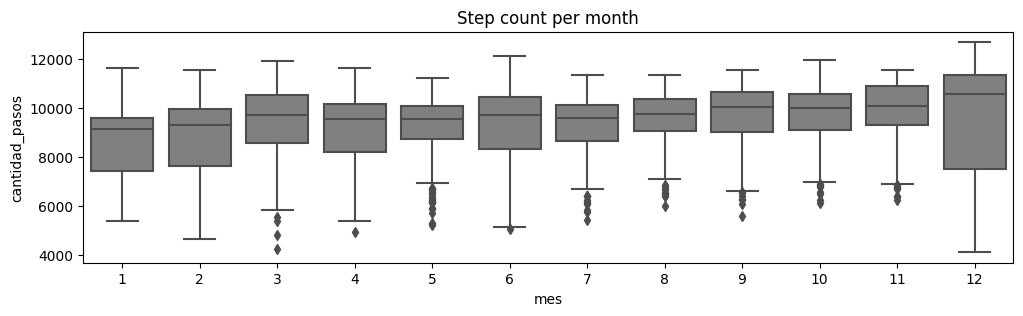

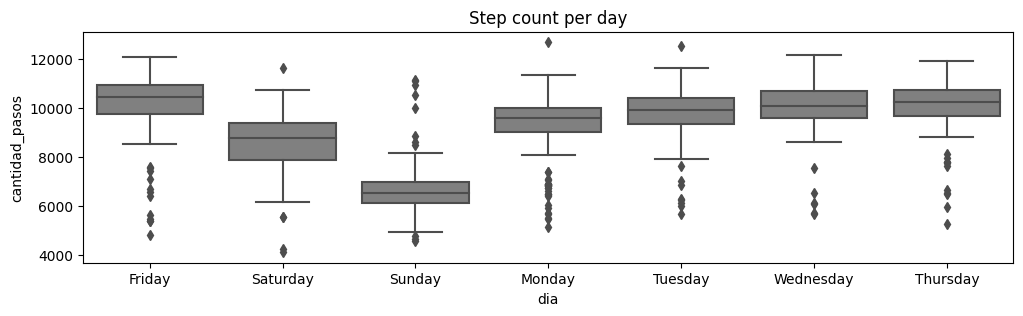

In [40]:
#Identify higher/lower days and months 
fig, ax = plt.subplots(figsize=(12, 3))
sns.boxplot(data=df_st, x='mes', y='cantidad_pasos', ax=ax, color="gray")
ax.set_title('Step count per month')

fig, ax = plt.subplots(figsize=(12, 3))
sns.boxplot(data=df_st, x='dia', y='cantidad_pasos', ax=ax, color="gray")
ax.set_title('Step count per day')

At first sight: 
- Saturdays and sundays show a lower mean than other days
- Fridays are the busiest day of the week 

In [32]:
#Testing dickey fuller for stationary  
X = df_st['cantidad_pasos'].values

result = adfuller(X)

print('\nFor the CONSOLIDATED 4 years')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')

for key, value in result[4].items():
    print('\t%5s: %8.3f' % (key, value)) 


For the CONSOLIDATED 4 years
ADF Statistic: -5.099164
p-value: 0.000014
Critical Values:
	   1%:   -3.436
	   5%:   -2.864
	  10%:   -2.568


At first sight: 
- Dickey-Fuller Null hipotesis is that the time series is not stationary. 
- P-value < 0.05, hence we reject the null hipotesis and we can assume series is stationary. However it has micro-cycles to account for. Arima, Sarima models might not be applicable  

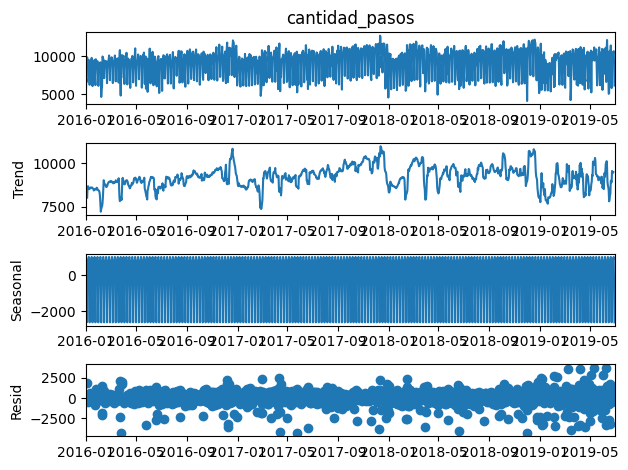

In [161]:
#descomponemos los elementos de la serie de tiempo

result_additive = seasonal_decompose(df_st['cantidad_pasos'], model='additive')
ax = result_additive.plot()

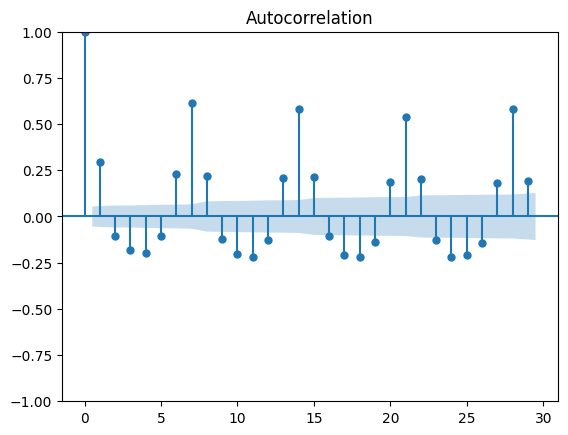

In [167]:
ax = plot_acf(df_st.cantidad_pasos, lags=np.arange(30))

## 3. Testing different models with Train function

In [91]:
#removing forecasting dates
df_st_actual =  df_st[0:1276]

In [92]:
#split in train and testing considering temporality
x= df_st_actual.index
y= df_st_actual.cantidad_pasos

y_train, y_test = temporal_train_test_split(y, test_size=90)

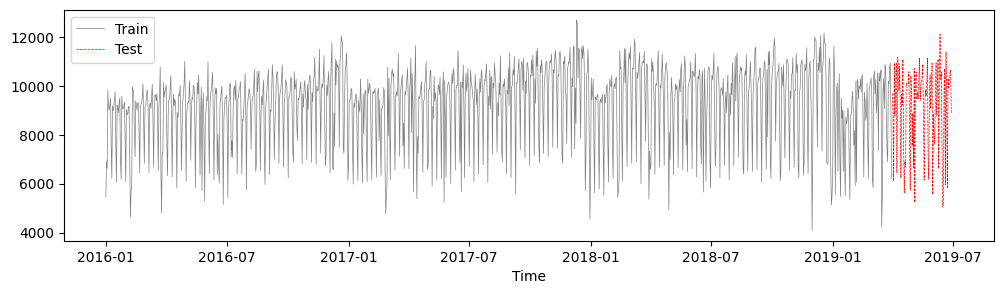

In [98]:
#plot the trend divided in training / testing 
fig, ax = plt.subplots(figsize=(12, 3))
ax.plot(y_train, ls='-', label='Train', color="gray", linewidth=0.5)
ax.plot(y_test, ls='--', label='Test', color="red", linewidth=0.5)
ax.set_xlabel('Time')
ax.legend(loc='best')

In [119]:
#forecast array
fh = pd.date_range(start="2019-04-01", end="2019-12-31")
fh

DatetimeIndex(['2019-04-01', '2019-04-02', '2019-04-03', '2019-04-04',
               '2019-04-05', '2019-04-06', '2019-04-07', '2019-04-08',
               '2019-04-09', '2019-04-10',
               ...
               '2019-12-22', '2019-12-23', '2019-12-24', '2019-12-25',
               '2019-12-26', '2019-12-27', '2019-12-28', '2019-12-29',
               '2019-12-30', '2019-12-31'],
              dtype='datetime64[ns]', length=275, freq='D')

In [111]:
#Generate the forecast using BATS 
from sktime.forecasting.bats import BATS

forecaster = BATS(use_box_cox=True,
                  use_trend=False,
                  use_damped_trend=False,
                  sp=[7, 30, 365])

In [104]:
forecaster

BATS(sp=[7, 30, 365], use_box_cox=True, use_damped_trend=False, use_trend=False)

In [113]:
fitted_bat = forecaster.fit(y_train)

In [120]:
y_pred_BATS = forecaster.predict(fh)

In [143]:
#Generate the forecast using TBATS 
from sktime.forecasting.tbats import TBATS
forecasterb = TBATS(use_box_cox=True,
                   use_trend=False,
                   use_damped_trend=False,
                   sp=[7, 30, 365])

In [144]:
fitted_tbat = forecasterb.fit(y_train)

In [151]:
y_pred_tBATS = forecasterb.predict(fh)

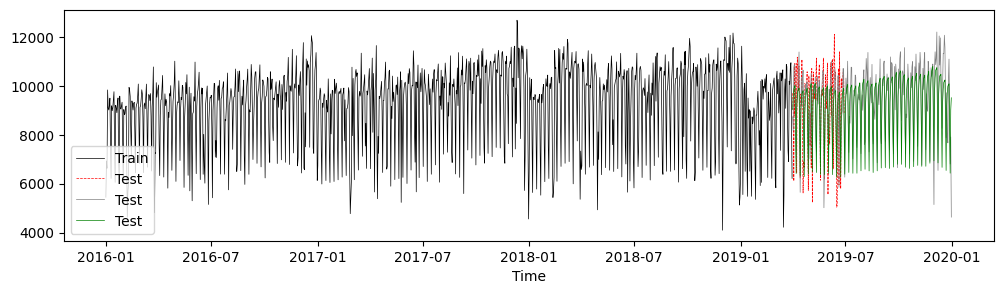

In [152]:
#Plot the train, test and predicted values to assess visually 
fig, ax = plt.subplots(figsize=(12, 3))

ax.plot(y_train, ls='-', label='Train', color="black", linewidth=0.5)
ax.plot(y_test, ls='--', label='Test', color="red", linewidth=0.5)
ax.plot(y_pred_BATS, ls='-', label='Test', color="gray", linewidth=0.5)
ax.plot(y_pred_tBATS, ls='-', label='Test', color="green", linewidth=0.5)
ax.set_xlabel('Time')
ax.legend(loc='best')

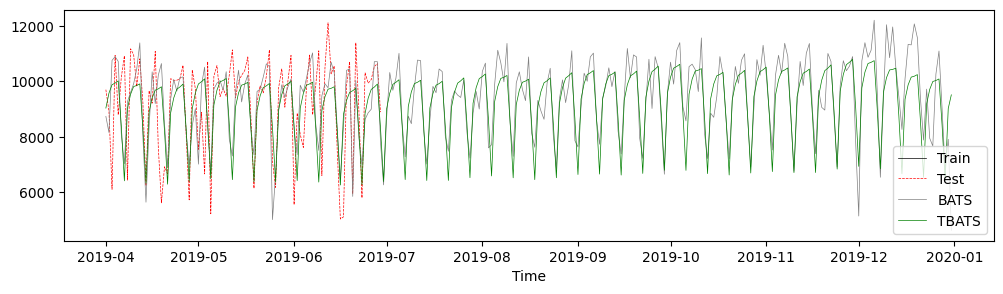

In [153]:
#Zoom in the forecasted period
y_train_zoom = y_train[1200:1276]

fig, ax = plt.subplots(figsize=(12, 3))
ax.plot(y_train_zoom, ls='-', label='Train', color="black", linewidth=0.5)
ax.plot(y_test, ls='--', label='Test', color="red", linewidth=0.5)
ax.plot(y_pred_BATS, ls='-', label='BATS', color="gray", linewidth=0.5)
ax.plot(y_pred_tBATS, ls='-', label='TBATS', color="green", linewidth=0.5)
ax.set_xlabel('Time')
ax.legend(loc='best')

## 4. Evaluating Models performance to down-select

In [124]:
#mean absolute percentage error calculation to evaluate the models
def mape(y_true, y_pred):
    return round(np.mean(np.abs((y_true - y_pred) / y_true)) * 100,2)

In [128]:
mape_BATS = mape(y_test, y_pred_BATS)
mape_BATS

15.07

In [154]:
mape_TBATS = mape(y_test, y_pred_tBATS)
mape_TBATS

14.8

At first sight: 
- TBATS performs better than BATS, however visually, the BATS model contemplates variances and potential outliers best than TBATS

## 5.Preparing Submission 

In [170]:
#save selected model results 
y_pred_BATS.to_csv( "C:/Users/sanie.s.rojas.lobo/Documents/uzzipped/forecasting_BATS.csv")